In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nozzle import Spectral, Params, Nozzle, Boundary
from scipy.integrate import simpson

# SINE

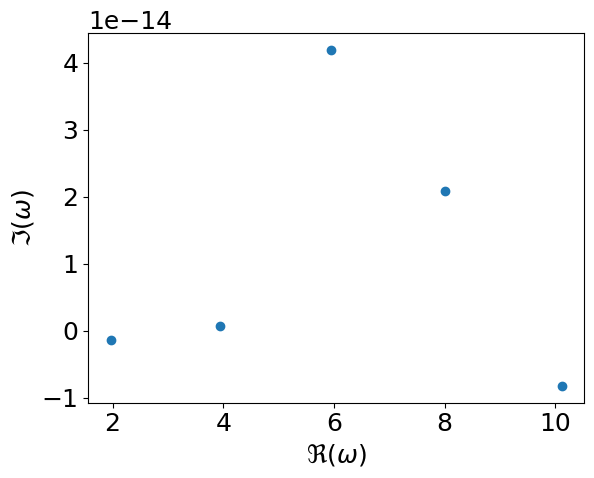

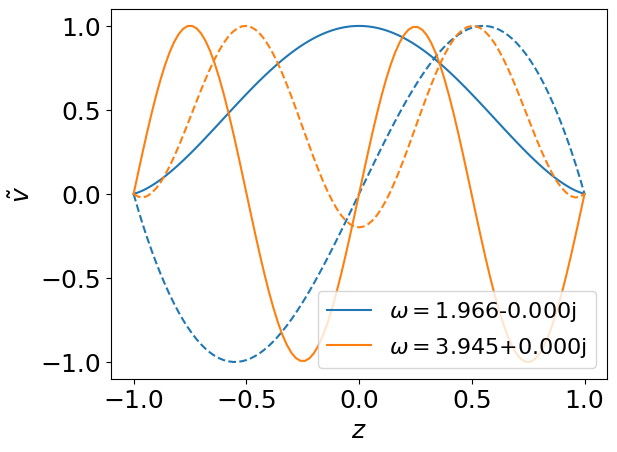

In [6]:
N = 50 # number of sine basis
M = 101 # number of points
Mm = 1.5
constant_v = True
accelerating = False
boundary = Boundary.FIXED_FIXED
params = Params(Mm, constant_v, accelerating, boundary)

spectral = Spectral(M, "symmetric", "FD")
x = spectral.x
D1 = spectral.D1
D2 = spectral.D2

nozzle = Nozzle(params, x, lambda x,n: u(x,n))
v0 = nozzle.v0

L = 2
x0 = -1
u = lambda x,n: np.sqrt(2/L)*np.sin(n*np.pi/L*(x-x0))

# A2 = np.eye(N,dtype=complex)
A2 = np.zeros((N,N),dtype=complex)
A1 = np.zeros((N,N),dtype=complex)
A0 = np.zeros((N,N),dtype=complex)
for i in range(1,N+1):
    for j in range(1,N+1):
        A2[i-1,j-1] = simpson(u(x,i)*u(x,j),x)
        A1[i-1,j-1] = 2j*simpson(u(x,i)*v0*(D1@u(x,j)) + u(x,i)*(D1@v0)*u(x,j),x)
        A0[i-1,j-1] = simpson(
            u(x,i)*(1-v0**2)*(D2@u(x,j)) -
            u(x,i)*(3*v0+1/v0)*(D1@v0)*(D1@u(x,j)) - 
            u(x,i)*(1-1/v0**2)*(D1@v0)**2*u(x,j) -
            u(x,i)*(v0+1/v0)*(D2@v0)*u(x,j),
            x)
        

C, nozzle.omega = nozzle.solve(A0,A1,A2)
nozzle.V = np.zeros((x.size, C.shape[1]),dtype=complex)
for i in range(C.shape[1]):
    for n in range(N):
            nozzle.V[:,i] += C[n,i]*u(x, n)
nozzle.sort_solutions(real_range=[0.1,11], imag_range=[-1,1])
nozzle.sort_solutions(real_range=[0,20], imag_range=[-1,1])
nozzle.plot_eigenvalues()
nozzle.plot_eigenfunctions(num_funcs=2)
nozzle.save_data("SE", N=N)